In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

from keras.models import Model,Sequential
from keras.layers import Input,Dense,LSTM,Bidirectional
from keras import backend as K
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM 
# import lstm, time #도움을 주는 라이브러리들

In [15]:
!pip install finance-datareader

In [16]:
import FinanceDataReader as fdr

In [17]:
# 10년치 데이터 불러오기
# 000020 동화약품 
data = fdr.DataReader('000020','2010-01-01','2020-10-23')

In [18]:
# 불필요한 컬럼 삭제
data = data.drop(['Change','Volume'],axis=1)

In [19]:
data

,Open,High,Low,Close
Date,,,,
2010-01-04,7540,7820,7480,7520
2010-01-05,7490,7580,7350,7500
2010-01-06,7500,7500,7320,7350
2010-01-07,7350,7420,7200,7210
2010-01-08,7220,7330,7220,7240
...,...,...,...,...
2020-10-19,21350,22900,20750,21300
2020-10-20,20850,21600,19850,20300
2020-10-21,20200,20500,19850,20100


In [23]:
# Normalization - 정규화
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_clos = ['Open','High','Low','Close']
df_scaled = scaler.fit_transform(data[scale_clos])

df_scaled = pd.DataFrame(data=df_scaled,columns=scale_clos)

df_scaled.head()

,Open,High,Low,Close
0,0.134017,0.122570,0.143140,0.131529
1,0.132118,0.114662,0.137999,0.130766
2,0.132498,0.112026,0.136813,0.125048
3,0.126803,0.109390,0.132068,0.119710
4,0.121868,0.106425,0.132859,0.120854


In [31]:
train = df_scaled[:2100] # 학습 데이터
test = df_scaled[2100:] # 테스트 데이터

In [32]:
# 학습 시킬 데이터 셋 생성 함수
# 30일 기반으로 데이터 셋 묶기
def make_dataset(data,label,window_size=30):
  feature_list =[] # 학습
  label_list =[] # 답
  for i in range(len(data)-window_size):
    feature_list.append(np.array(data.iloc[i:i+window_size]))
    label_list.append(np.array(label.iloc[i+window_size]))
  return np.array(feature_list),np.array(label_list)

In [33]:
feature_cols = ['Open','High','Low'] # 학습 컬럼
label_cols = ['Close'] # 답 컬럼

train_feature = train[feature_cols]
train_label = train[label_cols]

# train dataset
train_feature,train_label = make_dataset(train_feature,train_label,30)

# train,test set 생성
X_train,X_test,y_train,y_test = \
train_test_split(train_feature,train_label,test_size=0.8,shuffle=False)

test_feature = test[feature_cols]
test_label = test[label_cols]

# test dataset(실제 예측 데이터)
test_feature,test_label = make_dataset(test_feature,test_label,30)

In [70]:
# Keras를 활용한 LSTM 모델 생성
model = Sequential()
model.add(LSTM(
    64 # 처음에는 16 -> 64
    ,input_shape=(train_feature.shape[1],train_feature.shape[2])
    ,activation='relu'
    ,return_sequences = False
))
model.add(Dense(1))

In [35]:
import os
from keras.callbacks import EarlyStopping,ModelCheckpoint

In [92]:
# 모델의 학습
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

early_stop = EarlyStopping(monitor='loss',patience=2,verbose=1)  # 처음에는  patience 1

model.fit(X_train,y_train,epochs=150,batch_size=16
                   ,validation_data=(X_test,y_test)
                   ,callbacks=[early_stop]
                   ,shuffle = False
          )

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 64)                17408     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 17,473
Trainable params: 17,473
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
26/26 [==============================] - 1s 30ms/step - loss: 4.9312e-05 - val_loss: 2.6320e-04
Epoch 2/150
26/26 [==============================] - 1s 25ms/step - loss: 3.8596e-05 - val_loss: 1.1035e-04
Epoch 3/150
26/26 [==============================] - 1s 24ms/step - loss: 4.0667e-05 - val_loss: 1.7716e-04
Epoch 4/150
26/26 [==============================] - 1s 26ms/step - loss: 3.7315e-05 - val_loss: 9.9836e-05
Epoch 5/150
26/26 [==============================] - 1s 24ms/step - loss: 4.0452

In [93]:
# 예측
pred =model.predict(test_feature)

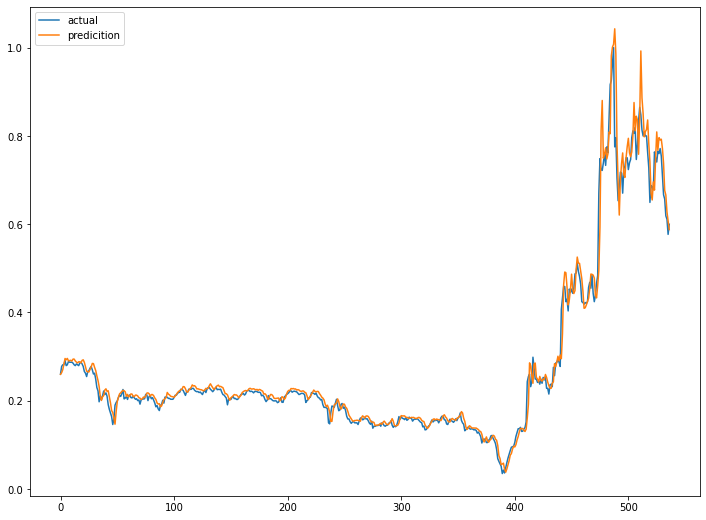

In [96]:
# 시각화
plt.figure(figsize=(12,9))
plt.plot(test_label,label='actual') # 실제
plt.plot(pred,label='predicition') # 예측
plt.legend()
plt.show()